In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
year_start = 1998
year_end = 2018
years_iter = range(year_start,year_end)

# Read cleaned data

- ## MSA data

In [172]:
df = {}
for year in years_iter:
    df[year] = pd.read_csv('data/cleaned/msa_naicssector_cleanedv2_totEmploy_'+str(year)+'.csv')

- ## State-country data

In [36]:
df_state = {}
for year in years_iter:
    df_state[year] = pd.read_csv('data/cleaned/state_naicssector_cleanedv2_totEmploy_'+str(year)+'.csv')

# Merge data

- ## MSA

In [41]:
for year in years_iter:
    df[year] = df[year].set_index(['MSA','NAICS Code'],drop=True)
    
tot_empl_all = df[year_start]
for year in range(year_start+1,year_end):
    tot_empl_all = pd.merge(tot_empl_all, df[year],how='inner' ,on=['MSA','NAICS Code'],copy=False )
    #df_all.to_csv('data/draft/df_all_merge_'+str(year)+'.csv')
    
tot_empl_all = tot_empl_all.T
tot_empl_all.index = list(years_iter)

- ## state-country

In [37]:
for year in years_iter:
    df_state[year] = df_state[year].set_index(['State','NAICS Code'],drop=True)

tot_empl_state_all = df_state[year_start]
for year in range(year_start+1,year_end):
    tot_empl_state_all = pd.merge(tot_empl_state_all, df_state[year],how='inner' ,on=['State','NAICS Code'],copy=False )
    
tot_empl_state_all = tot_empl_state_all.T
tot_empl_state_all.index = list(years_iter)

# Calculate PPC: point percent change

- ## MSA

In [75]:
tot_empl_ppc = tot_empl_all.diff().dropna()/tot_empl_all.shift().dropna()*100

- ## State-Country

In [74]:
tot_empl_state_ppc = tot_empl_state_all.diff().dropna()/tot_empl_state_all.shift().dropna()*100

# Utilities

- ## MSA to State 

In [78]:
MSA_df = pd.read_csv('data/MSA_wikipedia.csv',delimiter='\t')

MSAs = MSA_df['Metropolitan statistical area ']
MSA_shorts = MSAs.map(lambda x: x.split(',')[0].split('-')[0].lower() )
MSA_shorts_dict = {MSA_shorts.iloc[i]:
                   {'MSA': MSAs.iloc[i][:-1],
                    'State': MSAs.iloc[i].split(', ')[1].split(' ')[0] } for i in range(len(MSAs))  }


state_abbr_df = pd.read_csv('data/state_abbr.csv',delimiter='\t',names=['State','Abbr.'])
state_to_abbr_dict = { state_abbr_df['State'].iloc[i].title()[0:-1] :state_abbr_df['Abbr.'].iloc[i] for i in range(len(state_abbr_df)) }
state_to_abbr_dict['United States'] = 'US'

abbr_to_state_dict ={ v:k for k,v in state_to_abbr_dict.items()}

MSA_to_state_dict = { MSAs.iloc[i][:-1]: MSAs.iloc[i].split(', ')[1].split(' ')[0]  for i in range(len(MSAs))  }

- ## Compare MSA data to state and country data

In [97]:
def ppc_relative( MSA,NAICS_code ):
    return (tot_empl_ppc[ (MSA,NAICS_code) ]-tot_empl_state_ppc[ ( abbr_to_state_dict[MSA_to_state_dict[MSA]] ,NAICS_code) ],
            tot_empl_ppc[ (MSA,NAICS_code) ]-tot_empl_state_ppc[ ( 'United States' ,NAICS_code) ] )

- ## NAICS Codes

In [136]:
NAICS_df = pd.read_csv('data/NAICS_codes.csv',delimiter=',,')
NAICS_dict = { NAICS_df['NAICS Code'].iloc[i]:NAICS_df['Description'].iloc[i] for i in NAICS_df.index }
NAICS_dict['--'] = 'Total'
NAICS_dict

<ipython-input-136-c6f8ed77d060>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  NAICS_df = pd.read_csv('data/NAICS_codes.csv',delimiter=',,')


{'11': ' Agriculture, Forestry, Fishing and Hunting',
 '21': ' Mining, Quarrying, and Oil and Gas Extraction',
 '22': ' Utilities',
 '23': ' Construction',
 '31-33': ' Manufacturing',
 '42': ' Wholesale Trade',
 '44-45': ' Retail Trade',
 '48-49': ' Transportation and Warehousing',
 '51': ' Information',
 '52': ' Finance and Insurance',
 '53': ' Real Estate and Rental and Leasing',
 '54': ' Professional, Scientific, and Technical Services',
 '55': ' Management of Companies and Enterprises',
 '56': ' Administrative and Support and Waste Management and Remediation Services',
 '61': ' Educational Services',
 '62': ' Health Care and Social Assistance',
 '71': ' Arts, Entertainment, and Recreation',
 '72': ' Accommodation and Food Services',
 '81': ' Other Services (except Public Administration)',
 '92': ' Public Administration',
 '--': 'Total'}

- ## MSA rank by total Employment

In [199]:
msa_emp_rank_df =  df[2017][df[2017]['NAICS Code']=='--'].sort_values(by='Total Employment - 2017',ascending=False).reset_index(drop=True)
del msa_emp_rank_df['NAICS Code'], msa_emp_rank_df['Total Employment - 2017']
msa_emp_rank_df_dict = {i:msa_emp_rank_df['MSA'].iloc[i] for i in range(len(msa_emp_rank_df))  }

# Plots

- ## PPC for an MSA and naics

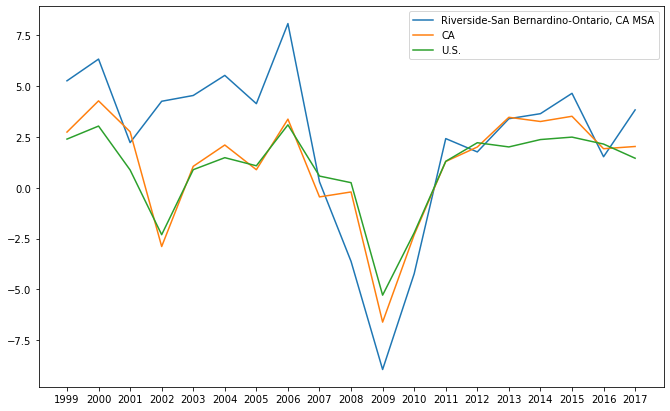

In [135]:
#MSA = 'Los Angeles-Long Beach-Anaheim, CA MSA'
MSA = 'Riverside-San Bernardino-Ontario, CA MSA'
#MSA = 'San Diego-Chula Vista-Carlsbad, CA MSA'
#MSA = 'Oxnard-Thousand Oaks-Ventura, CA MSA'
#MSA = 'Santa Maria-Santa Barbara, CA MSA'

#MSA = 'Denver-Aurora-Lakewood, CO MSA'
NAICS_code = '--'

plt.figure()

fsize = 7
plt.gcf().set_size_inches(fsize*1.6,fsize)

tot_empl_ppc[ (MSA,NAICS_code) ].plot(label=MSA)
tot_empl_state_ppc[ ( abbr_to_state_dict[MSA_to_state_dict[MSA]] ,NAICS_code) ].plot(label=MSA_to_state_dict[MSA])
tot_empl_state_ppc[ ( 'United States' ,NAICS_code) ].plot(label='U.S.')

ax = plt.gca()
ax.set_yticks( [0], minor=True )
ax.yaxis.grid(True, which='minor')

plt.legend()
plt.xticks(list(range(year_start+1,year_end) ));
#plt.grid(True)

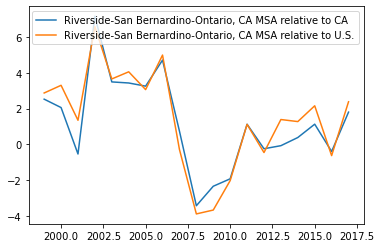

In [116]:
ppc_relative_state, ppc_relative_country =  ppc_relative(MSA,NAICS_code)
ppc_relative_state.plot(label=MSA+' relative to '+MSA_to_state_dict[MSA])
ppc_relative_country.plot(label=MSA+' relative to U.S.')
plt.legend()

# Correlation with house data
- ## Read, clean and Calculate PPC

In [186]:
house_df = pd.read_csv('data/other-data/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv')
del house_df['RegionID'], house_df['SizeRank'], house_df['RegionType'], house_df['StateName']
house_df.set_index('RegionName',drop=True,inplace=True)
house_df = house_df.T
house_df.index = pd.to_datetime(house_df.index)

house_df['Year'] = house_df.index.year
house_df = house_df.groupby(house_df['Year']).mean()
house_df = house_df.loc[ list(years_iter) ]

# calculate PPC
house_ppc_df = house_df.diff()/house_df.shift()*100
house_ppc_df = house_ppc_df.drop( house_ppc_df.index[0] )

In [140]:
def house_ppc_relative(MSA_rank):
    return house_ppc_df[house_ppc_df.columns[MSA_rank]]-house_ppc_df[house_ppc_df.columns[0]]

In [ ]:
houseRank_to_empRank = {1:'NaN', 2:0, 3:1, 4:2, 5:4, 6:5, 7:3, 8:8, 9:7,
                        10:6, 11:9, 12:'NaN', 13:17, 14:12, 15:11, 16:10, 17:14, 18:15, 19:18 ,
                        20:16, 21:13, 22:19, 23:'NaN', 24:22, 25:31, 26:26, 27:20, 28:24, 29:'NaN', 30:23 }

- ## Compare PPC

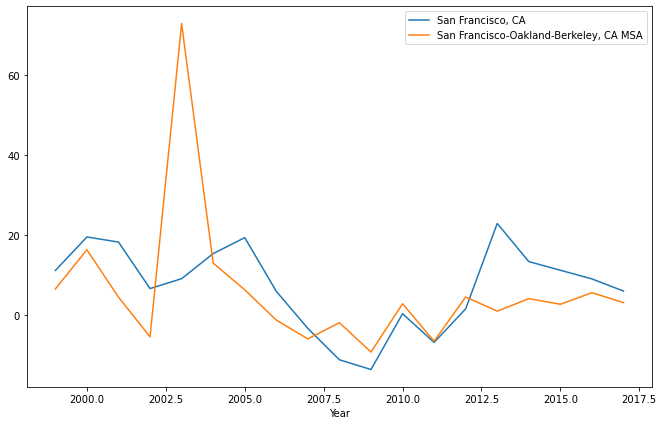

In [247]:
plt.figure()

fsize = 7
plt.gcf().set_size_inches(fsize*1.6,fsize)


MSA_rank = 11
house_ppc_df[house_ppc_df.columns[MSA_rank]].plot( label= house_ppc_df.columns[MSA_rank])


MSA_rank = houseRank_to_empRank[MSA_rank]
MSA = msa_emp_rank_df_dict[MSA_rank]
NAICS_code = '54'

tot_empl_ppc[ (MSA,NAICS_code) ].plot(label=MSA)

plt.legend()
#plt.ylim( (-10,10) )

- ## Compare Relative PPC

(-10.0, 10.0)

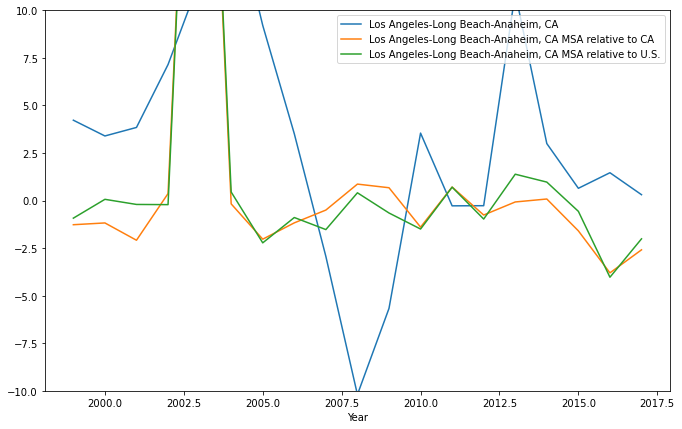

In [219]:
plt.figure()

fsize = 7
plt.gcf().set_size_inches(fsize*1.6,fsize)


MSA_rank = 2
house_ppc_relative(MSA_rank).plot( label= house_ppc_df.columns[MSA_rank])


MSA_rank = houseRank_to_empRank[MSA_rank]
MSA = msa_emp_rank_df_dict[MSA_rank]
NAICS_code = '--'
ppc_relative_state, ppc_relative_country =  ppc_relative(MSA,NAICS_code)
ppc_relative_state.plot(label=MSA+' relative to '+MSA_to_state_dict[MSA])
ppc_relative_country.plot(label=MSA+' relative to U.S.')

plt.legend()
plt.ylim( (-10,10) )

In [157]:
pd.to_datetime('1998',format='%Y').year

1998

# Draft

In [39]:
tot_empl_state_all['Wyoming']
tot_empl_state_all['California']
tot_empl_state_all['Alabama']
tot_empl_state_all

State      United States                                                       \
NAICS Code            --        11        21        22         23       31-33   
1998         108117731.0  187149.0  497849.0  682227.0  5798942.0  16946142.0   
1999         110705661.0  192155.0  456645.0  667062.0  6201626.0  16659930.0   
2000         114064976.0  183565.0  456128.0  655230.0  6572800.0  16473994.0   
2001         115061184.0  183476.0  485565.0  654484.0  6491994.0  15950424.0   
2002         112400654.0  181162.0  465775.0  648254.0  6307370.0  14393609.0   
2003         113398043.0  180673.0  454550.0  675938.0  6381404.0  14132020.0   
2004         115074924.0  182121.0  470280.0  634734.0  6647641.0  13821976.0   
2005         116317003.0  168744.0  497272.0  633106.0  6781327.0  13667337.0   
2006         119917165.0  165661.0  554333.0  614427.0  7338799.0  13631683.0   
2007         120604265.0  172105.0  700887.0  622757.0  7267883.0  13320172.0   
2008         120903551.0  167039.0  629271.0  639403.0  7043631.0  13096159.0   
2009         114509626.0  153829.0  604653.0  641552.0  5967128.0  11632956.0   
2010         111970095.0  156055.0  581582.0  638058.0  5389271.0  10862838.0   
2011         113425965.0  156520.0  651204.0  639795.0  5190921.0  10984361.0   
2012         115938468.0  161077.0  727626.0  641063.0  5260942.0  11192043.0   
2013         118266253.0  154496.0  732186.0  638575.0  5470181.0  11276438.0   
2014         121069944.0  156363.0  758971.0  637840.0  5705146.0  11424251.0   
2015         124085947.0  160144.0  743660.0  639234.0  6008286.0  11605501.0   
2016         126752238.0  160411.0  587017.0  638917.0  6311264.0  11590420.0   
2017         128591812.0  164046.0  578098.0  644703.0  6533061.0  11721785.0   

State                                                    ... Wyoming           \
NAICS Code         42       44-45      48-49         51  ...      42    44-45   
1998        5885230.0  14241512.0  3462624.0  3142024.0  ...  6172.0  26975.0   
1999        5972022.0  14476628.0  3627057.0  3234530.0  ...  6021.0  28136.0   
2000        6112029.0  14840775.0  3790002.0  3545731.0  ...  6574.0  28285.0   
2001        6142089.0  14890289.0  3750663.0  3754698.0  ...  6801.0  29408.0   
2002        5860256.0  14819904.0  3581013.0  3536120.0  ...  7094.0  29180.0   
2003        5863860.0  14867825.0  4067935.0  3599902.0  ...  6398.0  29420.0   
2004        5907051.0  15351431.0  4098870.0  3472427.0  ...  6533.0  30057.0   
2005        5968929.0  15338672.0  4168016.0  3402599.0  ...  6710.0  30186.0   
2006        6030647.0  15767866.0  4306405.0  3396246.0  ...  7031.0  31683.0   
2007        5964850.0  15759928.0  4395432.0  3399313.0  ...  7851.0  33066.0   
2008        6165204.0  15614757.0  4438903.0  3434234.0  ...  8388.0  33235.0   
2009        5827769.0  14802767.0  4159604.0  3288109.0  ...  8456.0  31960.0   
2010        5598507.0  14496625.0  4011989.0  3124036.0  ...  7632.0  30608.0   
2011        5626328.0  14698563.0  4106359.0  3121317.0  ...  7826.0  30100.0   
2012        5776243.0  14807958.0  4233381.0  3136025.0  ...  8460.0  30193.0   
2013        5908763.0  15023362.0  4287236.0  3266084.0  ...  8554.0  30004.0   
2014        5966747.0  15372632.0  4406767.0  3364530.0  ...  8676.0  31749.0   
2015        6076109.0  15704167.0  4616568.0  3394317.0  ...  8586.0  32372.0   
2016        6110748.0  15967893.0  4729709.0  3447950.0  ...  7910.0  31157.0   
2017        6115476.0  15705808.0  4866282.0  3507966.0  ...  7152.0  29298.0   

State                                                                           
NAICS Code    48-49      51      52       54      55      56       62       72  
1998         5313.0  3627.0  6131.0   6110.0  1200.0  4684.0  23694.0  22882.0  
1999         5255.0  3846.0  6826.0   6214.0  1222.0  5666.0  24481.0  23435.0  
2000         5343.0  3716.0  7122.0   6313.0  1356.0  5735.0  25398.0  24242.0  
2001         5656.0  3866.0  

In [113]:
tot_empl_all[MSA]

NAICS Code,--,11,21,22,23,31-33,42,44-45,48-49,51,...,53,54,55,56,61,62,71,72,81,99
1998,3693537.0,1188.0,2942.0,9183.0,120005.0,638415.0,263178.0,349755.0,139230.0,164271.0,...,80546.0,383442.0,80298.0,311832.0,95074.0,360719.0,69039.0,264384.0,158576.0,3535.0
1999,3747755.0,1067.0,2505.0,8774.0,133103.0,622885.0,264354.0,355417.0,143048.0,165873.0,...,83203.0,394384.0,81276.0,322551.0,98345.0,359599.0,70769.0,269701.0,165061.0,4275.0
2000,3863871.0,1007.0,2548.0,9333.0,140294.0,608230.0,277146.0,371627.0,156146.0,180551.0,...,85171.0,406503.0,83151.0,337840.0,105017.0,372844.0,74285.0,278078.0,169031.0,6178.0
2001,3889686.0,1254.0,2860.0,7650.0,141559.0,590921.0,277678.0,376071.0,153905.0,194658.0,...,87291.0,432820.0,77081.0,308986.0,108751.0,389885.0,76127.0,285542.0,169616.0,4037.0
2002,3791362.0,1557.0,2132.0,9022.0,130365.0,523293.0,294219.0,380817.0,145009.0,174757.0,...,86264.0,419161.0,82055.0,289353.0,110489.0,404110.0,70621.0,291661.0,175058.0,1146.0
2003,5218841.0,1967.0,2398.0,19889.0,234561.0,698121.0,370238.0,556034.0,186276.0,206061.0,...,126915.0,557402.0,129904.0,399738.0,131813.0,536847.0,110498.0,433285.0,223916.0,2425.0
2004,5319367.0,1874.0,2429.0,19872.0,240458.0,688863.0,367486.0,580888.0,189091.0,223320.0,...,131298.0,575016.0,129809.0,388729.0,142778.0,554490.0,114326.0,447360.0,221985.0,2966.0
2005,5258503.0,849.0,2404.0,20063.0,247111.0,666484.0,375403.0,568257.0,188992.0,232635.0,...,137004.0,474318.0,134530.0,406117.0,141215.0,548377.0,116895.0,467814.0,221928.0,1813.0
2006,5374338.0,1007.0,2783.0,20619.0,275416.0,648682.0,384120.0,585620.0,189743.0,252546.0,...,138878.0,474735.0,128025.0,422522.0,143994.0,567152.0,112732.0,472212.0,223214.0,1314.0
2007,5323109.0,891.0,3376.0,0.0,273864.0,622376.0,379811.0,590878.0,191861.0,248582.0,...,138092.0,489530.0,119725.0,406133.0,144179.0,578731.0,112764.0,483149.0,222540.0,568.0


In [217]:
msa_emp_rank_df.iloc[:35]

,MSA
0,"Los Angeles-Long Beach-Anaheim, CA MSA"
1,"Chicago-Naperville-Elgin, IL-IN-WI MSA"
2,"Dallas-Fort Worth-Arlington, TX MSA"
3,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA"
4,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA"
5,"Houston-The Woodlands-Sugar Land, TX MSA"
6,"Boston-Cambridge-Newton, MA-NH MSA"
7,"Atlanta-Sandy Springs-Alpharetta, GA MSA"
8,"Miami-Fort Lauderdale-West Palm Beach, FL MSA"
9,"San Francisco-Oakland-Berkeley, CA MSA"


In [218]:
houseRank_to_empRank = {1:'NaN', 2:0, 3:1, 4:2, 5:4, 6:5, 7:3, 8:8, 9:7,
                        10:6, 11:9, 12:'NaN', 13:17, 14:12, 15:11, 16:10, 17:14, 18:15, 19:18 ,
                        20:16, 21:13, 22:19, 23:'NaN', 24:22, 25:31, 26:26, 27:20, 28:24, 29:'NaN', 30:23 }
pd.DataFrame(house_ppc_df.columns[:35])

,RegionName
0,United States
1,"New York, NY"
2,"Los Angeles-Long Beach-Anaheim, CA"
3,"Chicago, IL"
4,"Dallas-Fort Worth, TX"
5,"Philadelphia, PA"
6,"Houston, TX"
7,"Washington, DC"
8,"Miami-Fort Lauderdale, FL"
9,"Atlanta, GA"
